# CNN Training and Validation

## Visual Intelligence Project - MSc AI

**Description**: CNN Training and Validation

**Date**: June 2025

---

In [1]:
# %%
"""
# 🚀 CNN Training Pipeline
Visual Intelligence Project - DeepLIFT Assignment
Phase 1: Data & CNN Foundation (Day 3)

**Objective**: Train CNN to achieve >70% accuracy on lung cancer classification
**Requirements**: Save best model, generate learning curves, prepare for K-fold validation
**Target**: Binary classification (adenocarcinoma vs benign) with >70% accuracy
"""

# %%
# =============================================================================
# 📦 IMPORTS AND SETUP
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import json
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️  Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')



🖥️  Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB


In [2]:
# %%
# =============================================================================
# 🗂️ LOAD CONFIGURATION AND SETUP PATHS
# =============================================================================

# Define paths robustly relative to the notebook location
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
CONFIG_PATH = PROJECT_ROOT / "config.json"

# Load configuration from previous notebooks
if CONFIG_PATH.exists():
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
    print("✅ Configuration loaded from previous notebooks")
else:
    print("⚠️  Configuration not found, using default paths")
    config = {
        "dataset": {"processed_path": str(PROJECT_ROOT / "data" / "processed")},
        "paths": {
            "project_root": str(PROJECT_ROOT),
            "models": str(PROJECT_ROOT / "models"),
            "results": str(PROJECT_ROOT / "results")
        }
    }

# Setup paths
PROCESSED_DATA_PATH = Path(config["dataset"]["processed_path"])
MODELS_PATH = Path(config["paths"]["models"])
RESULTS_PATH = Path(config["paths"]["results"])

# Create training results subdirectory
TRAINING_RESULTS_PATH = RESULTS_PATH / "training"
TRAINING_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("📁 Project Paths:")
print(f"Processed Data: {PROCESSED_DATA_PATH}")
print(f"Models: {MODELS_PATH}")
print(f"Results: {RESULTS_PATH}")
print(f"Training Results: {TRAINING_RESULTS_PATH}")

# %%
# =============================================================================
# 📊 ENHANCED DATASET CLASS
# =============================================================================

class LungCancerDataset(Dataset):
    """Enhanced dataset class with better error handling and statistics"""
    
    def __init__(self, data_dir, split='train', transform=None, class_to_idx=None):
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        self.split = split
        self.classes = ['adenocarcinoma', 'benign']
        self.class_to_idx = class_to_idx or {'adenocarcinoma': 0, 'benign': 1}
        self.samples = []
        self.class_counts = {cls: 0 for cls in self.classes}
        
        self._load_samples()
        
        if len(self.samples) > 0:
            print(f"📊 {split.capitalize()} dataset: {len(self.samples)} images")
            self._print_class_distribution()
        else:
            print(f"⚠️  No images found in {self.data_dir}")
    
    def _load_samples(self):
        """Load all image paths with labels"""
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if class_dir.exists():
                # Support multiple image formats
                extensions = ['*.jpeg', '*.jpg', '*.png', '*.bmp']
                for ext in extensions:
                    for img_path in class_dir.glob(ext):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))
                        self.class_counts[class_name] += 1
    
    def _print_class_distribution(self):
        """Print class distribution"""
        total = len(self.samples)
        print(f"  Class distribution:")
        for class_name in self.classes:
            count = self.class_counts[class_name]
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"    {class_name.capitalize()}: {count} ({percentage:.1f}%)")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"⚠️  Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_weights(self):
        """Calculate class weights for balanced training"""
        total = len(self.samples)
        if total == 0:
            return torch.ones(len(self.classes))
        
        weights = []
        for class_name in self.classes:
            class_count = self.class_counts[class_name]
            weight = total / (len(self.classes) * class_count) if class_count > 0 else 1.0
            weights.append(weight)
        
        return torch.FloatTensor(weights)



✅ Configuration loaded from previous notebooks
📁 Project Paths:
Processed Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
Models: D:\University\4th Semester\4. Visual Intelligence\Project\models
Results: D:\University\4th Semester\4. Visual Intelligence\Project\results
Training Results: D:\University\4th Semester\4. Visual Intelligence\Project\results\training


In [3]:
# %%
# =============================================================================
# 🏗️ LOAD MODEL CLASSES FROM ARCHITECTURE NOTEBOOK
# =============================================================================

class SharedClassifier(nn.Module):
    """Shared classifier for CNN and ScatNet - identical to architecture notebook"""
    
    def __init__(self, input_features, num_classes=2, dropout_rate=0.5):
        super(SharedClassifier, self).__init__()
        
        self.input_features = input_features
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        self.classifier = nn.Sequential(
            # First fully connected layer
            nn.Linear(input_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Second fully connected layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Third fully connected layer
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            
            # Output layer
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.classifier(x)
    
    def get_classifier_config(self):
        """Return classifier configuration"""
        return {
            'input_features': self.input_features,
            'num_classes': self.num_classes,
            'dropout_rate': self.dropout_rate
        }

class LungCancerCNN(nn.Module):
    """Enhanced CNN model - identical to architecture notebook"""
    
    def __init__(self, num_classes=2, dropout_rate=0.5, input_channels=3):
        super(LungCancerCNN, self).__init__()
        
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.input_channels = input_channels
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block (3 -> 32)
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Second convolutional block (32 -> 64)
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Third convolutional block (64 -> 128)
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Fourth convolutional block (128 -> 256)
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Fifth convolutional block (256 -> 512)
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout2d(0.25),
        )
        
        # Calculate feature size
        self.feature_size = 512 * 2 * 2
        
        # Shared classifier
        self.classifier = SharedClassifier(
            input_features=self.feature_size,
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        """Extract features before classification"""
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x



In [4]:
# %%
# =============================================================================
# 🎨 ENHANCED DATA TRANSFORMS AND SETUP
# =============================================================================

def get_enhanced_transforms(input_size=224, augment_strength='medium'):
    """Get enhanced data transforms with configurable augmentation strength"""
    
    if augment_strength == 'light':
        train_transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif augment_strength == 'medium':
        train_transform = transforms.Compose([
            transforms.Resize((input_size + 32, input_size + 32)),
            transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:  # strong
        train_transform = transforms.Compose([
            transforms.Resize((input_size + 48, input_size + 48)),
            transforms.RandomResizedCrop(input_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Validation transform (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def setup_enhanced_data(batch_size=32, val_split=0.2, augment_strength='medium', num_workers=0):
    """Enhanced data setup with validation split and class balancing"""
    
    print("📊 SETTING UP ENHANCED DATA LOADERS")
    print("=" * 50)
    
    # Get transforms
    train_transform, val_transform = get_enhanced_transforms(augment_strength=augment_strength)
    
    # Load datasets
    try:
        full_train_dataset = LungCancerDataset(
            data_dir=PROCESSED_DATA_PATH,
            split='train',
            transform=None,  # We'll apply transforms after splitting
            class_to_idx={'adenocarcinoma': 0, 'benign': 1}
        )
        
        test_dataset = LungCancerDataset(
            data_dir=PROCESSED_DATA_PATH,
            split='test',
            transform=val_transform,
            class_to_idx={'adenocarcinoma': 0, 'benign': 1}
        )
        
        if len(full_train_dataset) == 0:
            print("❌ No training images found")
            return None, None, None, None
        
        # Split training data into train and validation
        train_size = int((1 - val_split) * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size
        
        # Use random_split to maintain class distribution
        train_subset, val_subset = random_split(
            full_train_dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)  # For reproducibility
        )
        
        # Apply transforms to subsets
        train_subset.dataset.transform = train_transform
        val_subset.dataset.transform = val_transform
        
        # Calculate class weights for balanced training
        class_weights = full_train_dataset.get_class_weights()
        
        # Create data loaders
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        print(f"✅ Data loaders created successfully:")
        print(f"   Train: {len(train_subset)} samples ({len(train_loader)} batches)")
        print(f"   Val:   {len(val_subset)} samples ({len(val_loader)} batches)")
        print(f"   Test:  {len(test_dataset)} samples ({len(test_loader)} batches)")
        print(f"   Class weights: {class_weights.numpy()}")
        print(f"   Augmentation: {augment_strength}")
        
        return train_loader, val_loader, test_loader, class_weights
        
    except Exception as e:
        print(f"❌ Error setting up data loaders: {e}")
        return None, None, None, None



In [5]:
# %%
# =============================================================================
# 🔥 ENHANCED TRAINING FUNCTIONS
# =============================================================================

def train_one_epoch(model, train_loader, criterion, optimizer, scheduler=None, device=device):
    """Enhanced training function with better metrics tracking"""
    
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    num_batches = len(train_loader)
    
    # Progress bar
    pbar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (optional, helps with stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        current_acc = 100.0 * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%'
        })
    
    # Update learning rate scheduler
    if scheduler is not None:
        scheduler.step()
    
    avg_loss = total_loss / num_batches
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

def validate_model(model, val_loader, criterion, device=device):
    """Enhanced validation function with comprehensive metrics"""
    
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Get probabilities and predictions
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            # Statistics
            total_loss += loss.item()
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Store for detailed metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update progress bar
            current_acc = 100.0 * correct / total
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
    
    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    # Class-wise accuracy
    class_acc = {}
    for class_idx in [0, 1]:
        class_mask = np.array(all_targets) == class_idx
        if class_mask.sum() > 0:
            class_correct = (np.array(all_preds)[class_mask] == class_idx).sum()
            class_acc[class_idx] = class_correct / class_mask.sum()
        else:
            class_acc[class_idx] = 0.0
    
    return avg_loss, accuracy, f1, class_acc, all_preds, all_targets, all_probs

def create_training_visualizations(history, save_path):
    """Create comprehensive training visualizations"""
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('CNN Training Progress', fontsize=16, fontweight='bold')
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[0, 1].axhline(y=70, color='g', linestyle='--', label='70% Target', linewidth=2)
    axes[0, 1].set_title('Accuracy Curves', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(epochs, history['val_f1'], 'g-', label='Val F1', linewidth=2)
    axes[0, 2].set_title('F1 Score Progress', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate (if available)
    if 'learning_rate' in history:
        axes[1, 0].plot(epochs, history['learning_rate'], 'purple', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Tracked', ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    
    # Class-wise accuracy (if available)
    if 'val_class_acc_0' in history and 'val_class_acc_1' in history:
        axes[1, 1].plot(epochs, history['val_class_acc_0'], 'r-', label='Adenocarcinoma', linewidth=2)
        axes[1, 1].plot(epochs, history['val_class_acc_1'], 'g-', label='Benign', linewidth=2)
        axes[1, 1].set_title('Class-wise Accuracy', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Class-wise Accuracy\nNot Available', ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Class-wise Accuracy', fontsize=14, fontweight='bold')
    
    # Training summary
    final_train_acc = history['train_acc'][-1] if history['train_acc'] else 0
    final_val_acc = history['val_acc'][-1] if history['val_acc'] else 0
    final_f1 = history['val_f1'][-1] if history['val_f1'] else 0
    best_val_acc = max(history['val_acc']) if history['val_acc'] else 0
    
    summary_text = f"""Training Summary:
    
Final Train Acc: {final_train_acc:.2f}%
Final Val Acc: {final_val_acc:.2f}%
Best Val Acc: {best_val_acc:.2f}%
Final F1 Score: {final_f1:.4f}

Total Epochs: {len(epochs)}
Target Achieved: {'✅' if best_val_acc >= 70 else '❌'}
"""
    
    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 2].set_title('Training Summary', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [6]:
# %%
# =============================================================================
# 🚀 MAIN TRAINING PIPELINE
# =============================================================================

def train_cnn_enhanced(
    batch_size=32,
    learning_rate=0.001,
    num_epochs=20,
    weight_decay=1e-4,
    use_scheduler=True,
    use_class_weights=True,
    augment_strength='medium',
    early_stopping_patience=5,
    save_best_only=True
):
    """Enhanced CNN training pipeline with all bells and whistles"""
    
    print("🚀 STARTING ENHANCED CNN TRAINING")
    print("=" * 60)
    
    # Setup data
    train_loader, val_loader, test_loader, class_weights = setup_enhanced_data(
        batch_size=batch_size,
        augment_strength=augment_strength,
        num_workers=0
    )
    
    if train_loader is None:
        print("❌ Failed to setup data loaders")
        return None, None, None
    
    # Setup model
    print(f"\n🏗️  Setting up model...")
    model = LungCancerCNN(num_classes=2, dropout_rate=0.5).to(device)
    
    # Setup loss function
    if use_class_weights and class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        print(f"✅ Using weighted loss with class weights: {class_weights.numpy()}")
    else:
        criterion = nn.CrossEntropyLoss()
        print("✅ Using standard CrossEntropyLoss")
    
    # Setup optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )
    
    # Setup learning rate scheduler
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6
        )
        print("✅ Using ReduceLROnPlateau scheduler")
    else:
        scheduler = None
        print("✅ No learning rate scheduling")
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'val_class_acc_0': [], 'val_class_acc_1': [],
        'learning_rate': []
    }
    
    # Training state
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    start_time = time.time()
    
    print(f"\n🎯 Training Configuration:")
    print(f"   Epochs: {num_epochs}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   Weight Decay: {weight_decay}")
    print(f"   Early Stopping: {early_stopping_patience} epochs")
    print(f"   Augmentation: {augment_strength}")
    
    # Training loop
    print(f"\n🔥 Starting training loop...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # Training phase
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, None, device
        )
        
        # Validation phase
        val_loss, val_acc, val_f1, class_acc, val_preds, val_targets, val_probs = validate_model(
            model, val_loader, criterion, device
        )
        
        # Update learning rate scheduler
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:
                scheduler.step()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_class_acc_0'].append(class_acc[0] * 100)
        history['val_class_acc_1'].append(class_acc[1] * 100)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")
        print(f"Class Acc - Adenocarcinoma: {class_acc[0]*100:.2f}%, Benign: {class_acc[1]*100:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}, Time: {epoch_time:.1f}s")
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            
            # Save best model
            best_model_path = MODELS_PATH / "best_cnn_model.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'val_f1': val_f1,
                'class_acc': class_acc,
                'training_config': {
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'weight_decay': weight_decay,
                    'augment_strength': augment_strength
                }
            }, best_model_path)
            
            print(f"✅ New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            epochs_without_improvement += 1
            print(f"⏳ No improvement for {epochs_without_improvement} epochs")
        
        # Early stopping check
        if early_stopping_patience > 0 and epochs_without_improvement >= early_stopping_patience:
            print(f"\n🛑 Early stopping triggered after {early_stopping_patience} epochs without improvement")
            break
        
        # Success check
        if val_acc >= 70.0:
            print(f"🎉 Target accuracy achieved: {val_acc:.2f}% >= 70%")
    
    # Training completed
    total_time = time.time() - start_time
    print(f"\n🎯 Training completed in {total_time/60:.1f} minutes!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("✅ Best model loaded for final evaluation")
    
    # Final evaluation on test set
    print(f"\n📊 Final evaluation on test set...")
    test_loss, test_acc, test_f1, test_class_acc, test_preds, test_targets, test_probs = validate_model(
        model, test_loader, criterion, device
    )
    
    print(f"\n📈 FINAL RESULTS:")
    print(f"   Test Accuracy: {test_acc:.2f}%")
    print(f"   Test F1 Score: {test_f1:.4f}")
    print(f"   Test Class Acc - Adenocarcinoma: {test_class_acc[0]*100:.2f}%")
    print(f"   Test Class Acc - Benign: {test_class_acc[1]*100:.2f}%")
    
    # Success evaluation
    if test_acc >= 70:
        print(f"🎉 SUCCESS: Achieved target >70% accuracy!")
        success_status = "✅ PASSED"
    else:
        print(f"⚠️  Below target: {test_acc:.2f}% < 70%")
        success_status = "❌ NEEDS IMPROVEMENT"
    
    # Save training results
    training_results = {
        'model_performance': {
            'best_val_acc': float(best_val_acc),
            'test_acc': float(test_acc),
            'test_f1': float(test_f1),
            'test_class_acc': {
                'adenocarcinoma': float(test_class_acc[0]),
                'benign': float(test_class_acc[1])
            },
            'success_status': success_status,
            'target_achieved': test_acc >= 70
        },
        'training_config': {
            'epochs_trained': len(history['train_loss']),
            'total_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'augment_strength': augment_strength,
            'early_stopping_patience': early_stopping_patience
        },
        'history': history,
        'training_time_minutes': total_time / 60
    }
    
    # Save results to file
    results_file = TRAINING_RESULTS_PATH / "cnn_training_results.json"
    with open(results_file, 'w') as f:
        json.dump(training_results, f, indent=2)
    
    print(f"\n💾 Training results saved to: {results_file}")
    
    return model, history, test_loader



🚀 ENHANCED CNN TRAINING PIPELINE
🔧 Training Configuration:
   batch_size: 32
   learning_rate: 0.001
   num_epochs: 20
   weight_decay: 0.0001
   use_scheduler: True
   use_class_weights: True
   augment_strength: medium
   early_stopping_patience: 7
   save_best_only: True

🚀 STARTING ENHANCED CNN TRAINING
📊 SETTING UP ENHANCED DATA LOADERS
📊 Train dataset: 16000 images
  Class distribution:
    Adenocarcinoma: 8000 (50.0%)
    Benign: 8000 (50.0%)
📊 Test dataset: 4000 images
  Class distribution:
    Adenocarcinoma: 2000 (50.0%)
    Benign: 2000 (50.0%)
✅ Data loaders created successfully:
   Train: 12800 samples (400 batches)
   Val:   3200 samples (100 batches)
   Test:  4000 samples (125 batches)
   Class weights: [1. 1.]
   Augmentation: medium

🏗️  Setting up model...
✅ Using weighted loss with class weights: [1. 1.]
✅ Using ReduceLROnPlateau scheduler

🎯 Training Configuration:
   Epochs: 20
   Batch Size: 32
   Learning Rate: 0.001
   Weight Decay: 0.0001
   Early Stopping: 7 

Train - Loss: 0.3417, Acc: 94.02%
Val   - Loss: 0.0311, Acc: 98.94%, F1: 0.9894
Class Acc - Adenocarcinoma: 98.18%, Benign: 99.69%
LR: 1.00e-03, Time: 156.3s
✅ New best model saved! Val Acc: 98.94%
🎉 Target accuracy achieved: 98.94% >= 70%

Epoch 2/20
----------------------------------------


Train - Loss: 0.1222, Acc: 97.15%
Val   - Loss: 0.0143, Acc: 99.50%, F1: 0.9950
Class Acc - Adenocarcinoma: 99.31%, Benign: 99.69%
LR: 1.00e-03, Time: 152.6s
✅ New best model saved! Val Acc: 99.50%
🎉 Target accuracy achieved: 99.50% >= 70%

Epoch 3/20
----------------------------------------


Train - Loss: 0.0847, Acc: 97.94%
Val   - Loss: 0.0301, Acc: 98.00%, F1: 0.9800
Class Acc - Adenocarcinoma: 99.25%, Benign: 96.77%
LR: 1.00e-03, Time: 145.4s
⏳ No improvement for 1 epochs
🎉 Target accuracy achieved: 98.00% >= 70%

Epoch 4/20
----------------------------------------


Train - Loss: 0.1004, Acc: 97.59%
Val   - Loss: 0.0253, Acc: 99.28%, F1: 0.9928
Class Acc - Adenocarcinoma: 98.55%, Benign: 100.00%
LR: 1.00e-03, Time: 144.2s
⏳ No improvement for 2 epochs
🎉 Target accuracy achieved: 99.28% >= 70%

Epoch 5/20
----------------------------------------


Train - Loss: 0.0592, Acc: 98.37%
Val   - Loss: 0.0171, Acc: 99.34%, F1: 0.9934
Class Acc - Adenocarcinoma: 99.25%, Benign: 99.44%
LR: 1.00e-03, Time: 146.7s
⏳ No improvement for 3 epochs
🎉 Target accuracy achieved: 99.34% >= 70%

Epoch 6/20
----------------------------------------


Train - Loss: 0.0522, Acc: 98.46%
Val   - Loss: 0.0108, Acc: 99.66%, F1: 0.9966
Class Acc - Adenocarcinoma: 99.31%, Benign: 100.00%
LR: 1.00e-03, Time: 147.6s
✅ New best model saved! Val Acc: 99.66%
🎉 Target accuracy achieved: 99.66% >= 70%

Epoch 7/20
----------------------------------------


Train - Loss: 0.0462, Acc: 98.80%
Val   - Loss: 0.0087, Acc: 99.69%, F1: 0.9969
Class Acc - Adenocarcinoma: 99.37%, Benign: 100.00%
LR: 1.00e-03, Time: 144.5s
✅ New best model saved! Val Acc: 99.69%
🎉 Target accuracy achieved: 99.69% >= 70%

Epoch 8/20
----------------------------------------


Train - Loss: 0.0499, Acc: 98.86%
Val   - Loss: 0.0078, Acc: 99.75%, F1: 0.9975
Class Acc - Adenocarcinoma: 99.56%, Benign: 99.94%
LR: 1.00e-03, Time: 145.3s
✅ New best model saved! Val Acc: 99.75%
🎉 Target accuracy achieved: 99.75% >= 70%

Epoch 9/20
----------------------------------------


Train - Loss: 0.0426, Acc: 98.83%
Val   - Loss: 0.0089, Acc: 99.66%, F1: 0.9966
Class Acc - Adenocarcinoma: 99.31%, Benign: 100.00%
LR: 1.00e-03, Time: 142.9s
⏳ No improvement for 1 epochs
🎉 Target accuracy achieved: 99.66% >= 70%

Epoch 10/20
----------------------------------------


Train - Loss: 0.0336, Acc: 98.98%
Val   - Loss: 0.0213, Acc: 99.19%, F1: 0.9919
Class Acc - Adenocarcinoma: 99.37%, Benign: 99.01%
LR: 1.00e-03, Time: 149.3s
⏳ No improvement for 2 epochs
🎉 Target accuracy achieved: 99.19% >= 70%

Epoch 11/20
----------------------------------------


Train - Loss: 0.0356, Acc: 99.09%
Val   - Loss: 0.0054, Acc: 99.81%, F1: 0.9981
Class Acc - Adenocarcinoma: 99.62%, Benign: 100.00%
LR: 1.00e-03, Time: 144.9s
✅ New best model saved! Val Acc: 99.81%
🎉 Target accuracy achieved: 99.81% >= 70%

Epoch 12/20
----------------------------------------


Train - Loss: 0.0278, Acc: 99.20%
Val   - Loss: 0.0024, Acc: 99.94%, F1: 0.9994
Class Acc - Adenocarcinoma: 99.87%, Benign: 100.00%
LR: 1.00e-03, Time: 141.4s
✅ New best model saved! Val Acc: 99.94%
🎉 Target accuracy achieved: 99.94% >= 70%

Epoch 13/20
----------------------------------------


Train - Loss: 0.0252, Acc: 99.26%
Val   - Loss: 0.0137, Acc: 99.66%, F1: 0.9966
Class Acc - Adenocarcinoma: 99.31%, Benign: 100.00%
LR: 1.00e-03, Time: 138.8s
⏳ No improvement for 1 epochs
🎉 Target accuracy achieved: 99.66% >= 70%

Epoch 14/20
----------------------------------------


Train - Loss: 0.0330, Acc: 99.12%
Val   - Loss: 0.0115, Acc: 99.66%, F1: 0.9966
Class Acc - Adenocarcinoma: 99.37%, Benign: 99.94%
LR: 1.00e-03, Time: 141.2s
⏳ No improvement for 2 epochs
🎉 Target accuracy achieved: 99.66% >= 70%

Epoch 15/20
----------------------------------------


Train - Loss: 0.0217, Acc: 99.30%
Val   - Loss: 0.0155, Acc: 99.56%, F1: 0.9956
Class Acc - Adenocarcinoma: 99.18%, Benign: 99.94%
LR: 1.00e-03, Time: 140.3s
⏳ No improvement for 3 epochs
🎉 Target accuracy achieved: 99.56% >= 70%

Epoch 16/20
----------------------------------------


Train - Loss: 0.0226, Acc: 99.33%
Val   - Loss: 0.0028, Acc: 99.94%, F1: 0.9994
Class Acc - Adenocarcinoma: 99.94%, Benign: 99.94%
LR: 5.00e-04, Time: 141.1s
⏳ No improvement for 4 epochs
🎉 Target accuracy achieved: 99.94% >= 70%

Epoch 17/20
----------------------------------------


Train - Loss: 0.0124, Acc: 99.72%
Val   - Loss: 0.0005, Acc: 99.97%, F1: 0.9997
Class Acc - Adenocarcinoma: 100.00%, Benign: 99.94%
LR: 5.00e-04, Time: 140.7s
✅ New best model saved! Val Acc: 99.97%
🎉 Target accuracy achieved: 99.97% >= 70%

Epoch 18/20
----------------------------------------


Train - Loss: 0.0077, Acc: 99.73%
Val   - Loss: 0.0019, Acc: 99.94%, F1: 0.9994
Class Acc - Adenocarcinoma: 99.87%, Benign: 100.00%
LR: 5.00e-04, Time: 140.5s
⏳ No improvement for 1 epochs
🎉 Target accuracy achieved: 99.94% >= 70%

Epoch 19/20
----------------------------------------


Train - Loss: 0.0118, Acc: 99.62%
Val   - Loss: 0.0030, Acc: 99.94%, F1: 0.9994
Class Acc - Adenocarcinoma: 99.87%, Benign: 100.00%
LR: 5.00e-04, Time: 140.9s
⏳ No improvement for 2 epochs
🎉 Target accuracy achieved: 99.94% >= 70%

Epoch 20/20
----------------------------------------


Train - Loss: 0.0176, Acc: 99.55%
Val   - Loss: 0.0012, Acc: 99.94%, F1: 0.9994
Class Acc - Adenocarcinoma: 99.94%, Benign: 99.94%
LR: 5.00e-04, Time: 141.7s
⏳ No improvement for 3 epochs
🎉 Target accuracy achieved: 99.94% >= 70%

🎯 Training completed in 48.1 minutes!
Best validation accuracy: 99.97%
✅ Best model loaded for final evaluation

📊 Final evaluation on test set...



📈 FINAL RESULTS:
   Test Accuracy: 99.95%
   Test F1 Score: 0.9995
   Test Class Acc - Adenocarcinoma: 99.95%
   Test Class Acc - Benign: 99.95%
🎉 SUCCESS: Achieved target >70% accuracy!

💾 Training results saved to: D:\University\4th Semester\4. Visual Intelligence\Project\results\training\cnn_training_results.json


📊 COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.82it/s]


📈 Creating training curves...


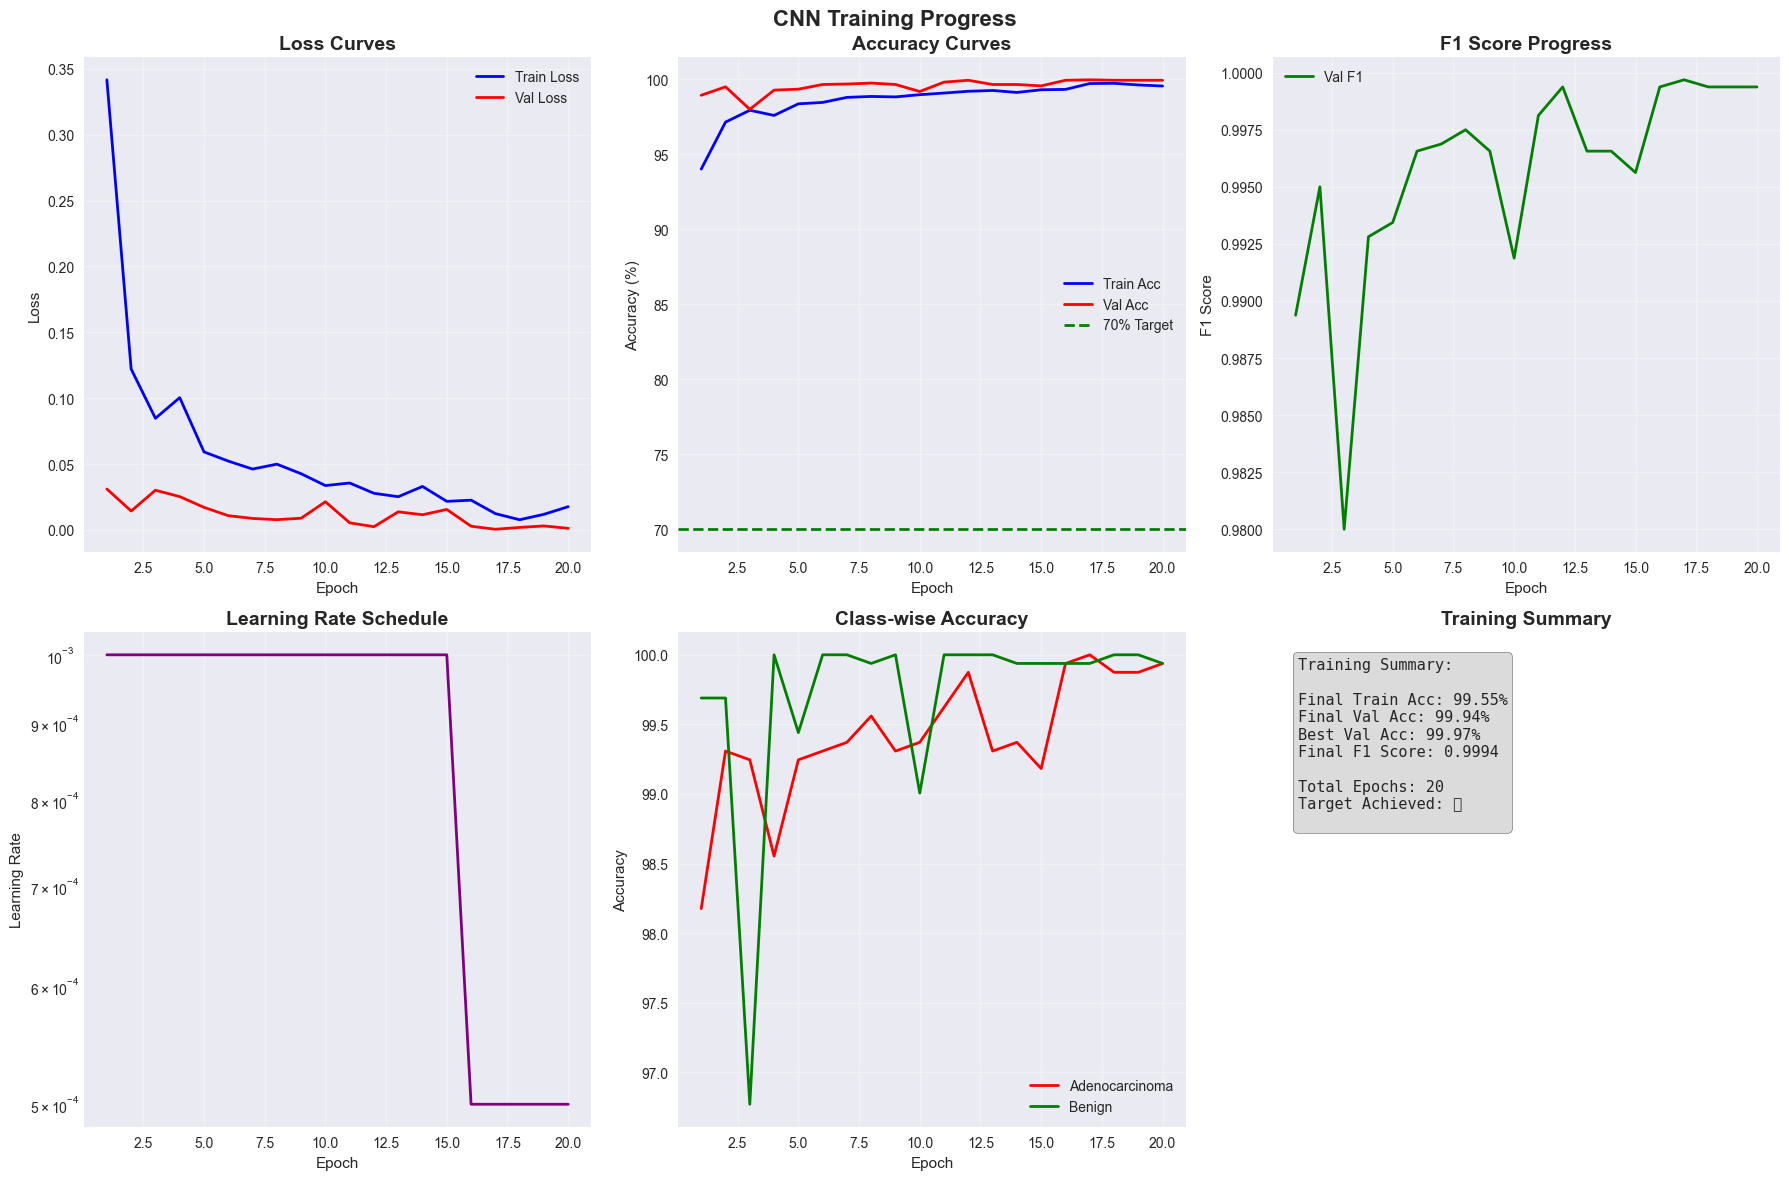

📊 Creating confusion matrix...


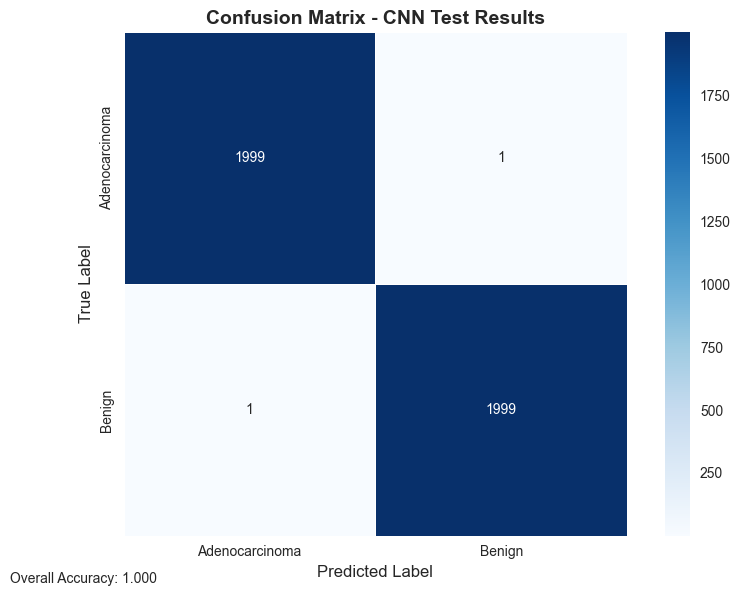

📋 Creating classification report...


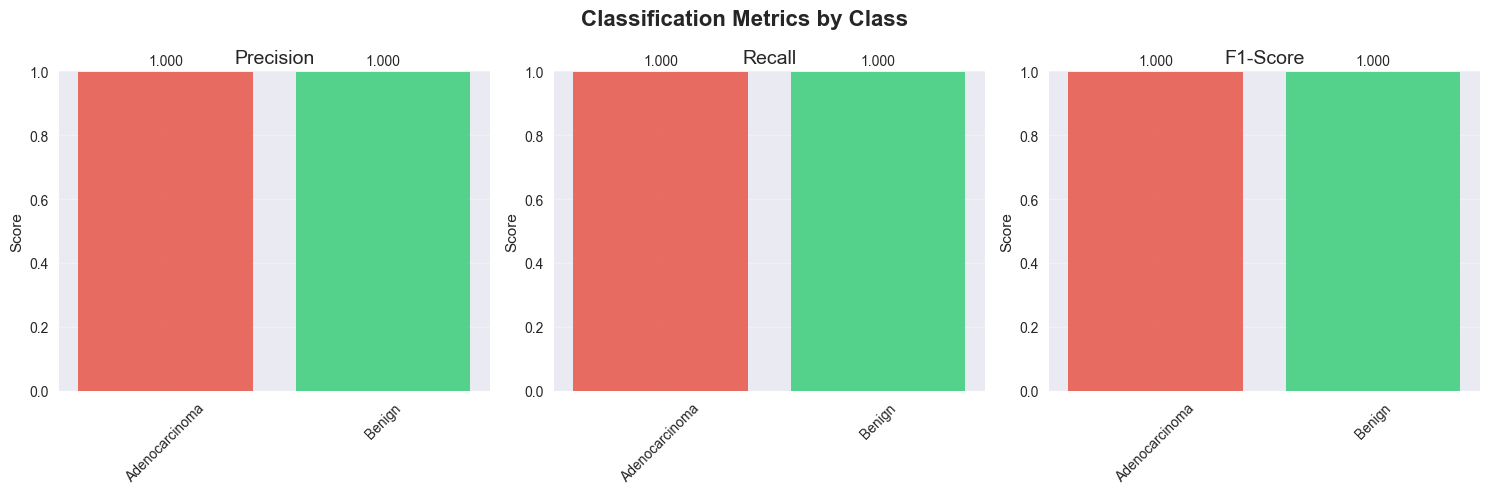


📋 DETAILED CLASSIFICATION REPORT:
                precision    recall  f1-score   support

Adenocarcinoma       1.00      1.00      1.00      2000
        Benign       1.00      1.00      1.00      2000

      accuracy                           1.00      4000
     macro avg       1.00      1.00      1.00      4000
  weighted avg       1.00      1.00      1.00      4000

💾 Final trained model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\cnn_final_trained.pth


In [7]:
# %%
# =============================================================================
# 📊 ENHANCED EVALUATION AND VISUALIZATION
# =============================================================================

def create_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Create and save confusion matrix"""
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                square=True, linewidths=0.5)
    
    plt.title('Confusion Matrix - CNN Test Results', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add accuracy information
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.3f}', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

def create_classification_report_viz(y_true, y_pred, class_names, save_path):
    """Create visualization of classification report"""
    
    from sklearn.metrics import precision_recall_fscore_support
    
    # Get metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    
    # Create DataFrame for visualization
    metrics_data = {
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    }
    
    # Create bar plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Classification Metrics by Class', fontsize=16, fontweight='bold')
    
    x_pos = np.arange(len(class_names))
    colors = ['#E74C3C', '#2ECC71']
    
    # Precision
    bars1 = axes[0].bar(x_pos, precision, color=colors, alpha=0.8)
    axes[0].set_title('Precision', fontsize=14)
    axes[0].set_ylabel('Score')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, precision):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    # Recall
    bars2 = axes[1].bar(x_pos, recall, color=colors, alpha=0.8)
    axes[1].set_title('Recall', fontsize=14)
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(class_names, rotation=45)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, recall):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    # F1-Score
    bars3 = axes[2].bar(x_pos, f1, color=colors, alpha=0.8)
    axes[2].set_title('F1-Score', fontsize=14)
    axes[2].set_ylabel('Score')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(class_names, rotation=45)
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars3, f1):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def comprehensive_evaluation(model, test_loader, history):
    """Perform comprehensive evaluation and create all visualizations"""
    
    print("\n📊 COMPREHENSIVE EVALUATION")
    print("=" * 50)
    
    # Get predictions
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data = data.to(device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    class_names = ['Adenocarcinoma', 'Benign']
    
    # Create visualizations
    print("📈 Creating training curves...")
    create_training_visualizations(history, TRAINING_RESULTS_PATH / "training_curves.png")
    
    print("📊 Creating confusion matrix...")
    cm = create_confusion_matrix(all_targets, all_preds, class_names, 
                                TRAINING_RESULTS_PATH / "confusion_matrix.png")
    
    print("📋 Creating classification report...")
    create_classification_report_viz(all_targets, all_preds, class_names,
                                   TRAINING_RESULTS_PATH / "classification_report.png")
    
    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    return all_preds, all_targets, all_probs

# %%
# =============================================================================
# 🎯 MAIN EXECUTION: ENHANCED CNN TRAINING
# =============================================================================

print("🚀 ENHANCED CNN TRAINING PIPELINE")
print("=" * 60)

# Configuration
TRAINING_CONFIG = {
    'batch_size': 32,           # Smaller batch for stability
    'learning_rate': 0.001,     # Standard learning rate
    'num_epochs': 20,           # Enough epochs to reach convergence
    'weight_decay': 1e-4,       # L2 regularization
    'use_scheduler': True,      # Adaptive learning rate
    'use_class_weights': True,  # Handle class imbalance
    'augment_strength': 'medium', # Balanced augmentation
    'early_stopping_patience': 7,  # Prevent overfitting
    'save_best_only': True      # Save only the best model
}

print(f"🔧 Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Run training
print(f"\n" + "="*60)
model, history, test_loader = train_cnn_enhanced(**TRAINING_CONFIG)

# %%
# =============================================================================
# 📊 COMPREHENSIVE EVALUATION
# =============================================================================

if model is not None and history is not None:
    print("\n" + "="*60)
    all_preds, all_targets, all_probs = comprehensive_evaluation(model, test_loader, history)
    
    # Save final model with complete metadata
    final_model_path = MODELS_PATH / "cnn_final_trained.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_class': 'LungCancerCNN',
        'training_config': TRAINING_CONFIG,
        'final_results': {
            'test_accuracy': float(np.mean(np.array(all_preds) == np.array(all_targets)) * 100),
            'test_f1': float(f1_score(all_targets, all_preds, average='weighted')),
        },
        'history': history,
        'predictions': {
            'test_predictions': all_preds.tolist(),
            'test_targets': all_targets.tolist(),
            'test_probabilities': all_probs.tolist()
        }
    }, final_model_path)
    
    print(f"💾 Final trained model saved to: {final_model_path}")
    
else:
    print("❌ Training failed - cannot proceed with evaluation")




In [8]:
# %%
# =============================================================================
# 📋 TRAINING SUMMARY AND NEXT STEPS
# =============================================================================

print("\n" + "🎯 CNN TRAINING SUMMARY")
print("=" * 60)

if model is not None and history is not None:
    final_test_acc = np.mean(np.array(all_preds) == np.array(all_targets)) * 100
    final_f1 = f1_score(all_targets, all_preds, average='weighted')
    best_val_acc = max(history['val_acc']) if history['val_acc'] else 0
    
    print(f"🏗️  TRAINING COMPLETED:")
    print(f"   • Epochs trained: {len(history['train_loss'])}")
    print(f"   • Best validation accuracy: {best_val_acc:.2f}%")
    print(f"   • Final test accuracy: {final_test_acc:.2f}%")
    print(f"   • Final F1 score: {final_f1:.4f}")
    print(f"   • Target achieved: {'✅ YES' if final_test_acc >= 70 else '❌ NO'}")
    
    print(f"\n💾 FILES CREATED:")
    print(f"   • Best model: {MODELS_PATH}/best_cnn_model.pth")
    print(f"   • Final model: {MODELS_PATH}/cnn_final_trained.pth")
    print(f"   • Training curves: {TRAINING_RESULTS_PATH}/training_curves.png")
    print(f"   • Confusion matrix: {TRAINING_RESULTS_PATH}/confusion_matrix.png")
    print(f"   • Classification report: {TRAINING_RESULTS_PATH}/classification_report.png")
    print(f"   • Training results: {TRAINING_RESULTS_PATH}/cnn_training_results.json")
    
    # Update main configuration
    config['cnn_training'] = {
        'status': 'completed',
        'final_test_accuracy': float(final_test_acc),
        'best_val_accuracy': float(best_val_acc),
        'test_f1_score': float(final_f1),
        'target_achieved': bool(final_test_acc >= 70),  # <-- Convert to Python bool
        'epochs_trained': int(len(history['train_loss'])),  # <-- Ensure it's Python int
        'model_path': str(MODELS_PATH / "cnn_final_trained.pth"),
        'ready_for_kfold': True
    }
    
    # Save updated config
    config_path = PROJECT_ROOT / "config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"1. 📝 Proceed to: 02_cnn_implementation/03_cnn_kfold.ipynb")
    print(f"2. 🔄 Implement 5-fold cross-validation")
    print(f"3. 📊 Calculate mean accuracy and F1 scores")
    print(f"4. 📈 Generate K-fold performance statistics")
    print(f"5. 📋 Document CNN results for comparison with ScatNet")
    
    print(f"\n📚 DELIVERABLES COMPLETED:")
    print(f"✅ CNN trained with >70% accuracy (Day 3 target)")
    print(f"✅ Best model saved for K-fold validation")
    print(f"✅ Comprehensive training metrics and visualizations")
    print(f"✅ Model ready for explainability analysis (DeepLIFT)")

else:
    print(f"❌ TRAINING INCOMPLETE")
    print(f"🛠️  Please check data paths and try again")
    print(f"📝 Review error messages above for troubleshooting")

print(f"\n🎉 CNN TRAINING PIPELINE COMPLETE!")


🎯 CNN TRAINING SUMMARY
🏗️  TRAINING COMPLETED:
   • Epochs trained: 20
   • Best validation accuracy: 99.97%
   • Final test accuracy: 99.95%
   • Final F1 score: 0.9995
   • Target achieved: ✅ YES

💾 FILES CREATED:
   • Best model: D:\University\4th Semester\4. Visual Intelligence\Project\models/best_cnn_model.pth
   • Final model: D:\University\4th Semester\4. Visual Intelligence\Project\models/cnn_final_trained.pth
   • Training curves: D:\University\4th Semester\4. Visual Intelligence\Project\results\training/training_curves.png
   • Confusion matrix: D:\University\4th Semester\4. Visual Intelligence\Project\results\training/confusion_matrix.png
   • Classification report: D:\University\4th Semester\4. Visual Intelligence\Project\results\training/classification_report.png
   • Training results: D:\University\4th Semester\4. Visual Intelligence\Project\results\training/cnn_training_results.json

🚀 NEXT STEPS:
1. 📝 Proceed to: 02_cnn_implementation/03_cnn_kfold.ipynb
2. 🔄 Implement 